# Atak adwersarialny na filtr spamu przy użyciu TextAttack

Ten notatnik demonstruje, jak przeprowadzić atak zwodniczy na model wykrywania spamu przy użyciu biblioteki `textattack`. Użyjemy przepisu ataku `TextBugger` przeciwko filtrowi spamu opartemu na BERT-Tiny.

In [10]:
# Importowanie niezbędnych bibliotek
import textattack
import transformers
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019, TextBuggerLi2018, DeepWordBugGao2018
from textattack import Attacker
from textattack.loggers import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# textattack: Główna biblioteka do ataków adwerialnych
# transformers: Biblioteka Hugging Face do modeli NLP.
# HuggingFaceModelWrapper: Wrapper, który pozwala TextAttack korzystać z modeli Hugging Face.
# HuggingFaceDataset: Klasa do ładowania zbiorów danych z Hugging Face.
# TextFoolerJin2019, TextBuggerLi2018, DeepWordBugGao2018: Gotowe przepisy (recipes) ataków.
# Attacker: Klasa zarządzająca procesem ataku.
# CSVLogger: Do zapisywania wyników w pliku CSV.

## 1. Ładowanie modelu i tokenizera

Użyjemy `mrm8488/bert-tiny-finetuned-sms-spam-detection`, modelu BERT-Tiny dostrojonego na zbiorze danych SMS Spam. Ten model jest stosunkowo mały i dosyć podatny na ataki.

In [11]:
# Nazwa modelu do pobrania z Hugging Face Hub
model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"

# Załadowanie modelu klasyfikacji sekwencji
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
# Załadowanie tokenizera odpowiadającego modelowi
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# Opakowanie modelu i tokenizera w wrapper TextAttack, aby biblioteka mogła z nich korzystać
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

## 2. Załadowanie zbioru danych

Użyjemy zbioru danych `sms_spam` z biblioteki `datasets` Hugging Face. Uwaga: `sms_spam` zawiera tylko podział 'train', więc go użyjemy.

In [12]:
# Załaduj zbiór danych (sms_spam ma tylko podział 'train')
# Musimy również określić kolumny zbioru danych, ponieważ textattack nie rozpoznaje automatycznie 'sms' jako kolumny wejściowej
dataset = HuggingFaceDataset("sms_spam", split="train", shuffle=True, dataset_columns=(['sms'], 'label'))

Using the latest cached version of the dataset since sms_spam couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\Damian\.cache\huggingface\datasets\sms_spam\plain_text\0.0.0\cae486f927c250fe1d4a5b55f11357964ed1646c (last modified on Tue Jan 27 11:23:02 2026).
textattack: Loading datasets dataset sms_spam, split train.


# 3.  Definicja Ataków Przeciwnych (Adversarial Attacks)

W tej analizie skupimy się na trzech metodach generowania przeciwnych przykładów tekstowych. Użyjemy **TextBugger** (`TextBuggerLi2018`) jako głównego ataku, a **TextFooler** i **DeepWordBug** jako alternatyw porównawczych.

---

## 3.1. Główny Atak: TextBugger (`TextBuggerLi2018`)

TextBugger jest **hybrydowym** atakiem typu **black-box**, zaprojektowanym do wprowadzania **minimalnych, zrozumiałych perturbacji** (zwanych "bugami") do tekstu. Jego celem jest spowodowanie błędnej klasyfikacji przez model docelowy przy jednoczesnym zachowaniu *utility* (zrozumiałości i użyteczności) dla ludzkiego oka.

###  Mechanizm działania

1.  **Identyfikacja Krytycznych Słów:** Atak najpierw wybiera słowa, które mają **największy wpływ** na pierwotną klasyfikację, mierząc spadek pewności modelu po ich usunięciu.
2.  **Generowanie Perturbacji (Bugów):** Dla każdego krytycznego słowa generowane są kandydatury zmian na dwóch poziomach:

| Poziom | Typ Perturbacji | Opis | Przykład (`love`) |
| :--- | :--- | :--- | :--- |
| **Słowo (Word)** | Podstawianie (Sub-W) | Zastąpienie słowa **synonimem** lub semantycznie bliskim sąsiadem (z wektorów embeddings lub WordNet). | `love` $\rightarrow$ `affection` |
| **Znak (Character)** | Wstawianie (Insert-C) | Wstawienie losowej litery lub spacji wewnątrz słowa. | `love` $\rightarrow$ `l ove` |
| **Znak (Character)** | Zamiana (Swap-C) | Zamiana sąsiednich znaków wewnątrz słowa. | `love` $\rightarrow$ `lvoe` |
| **Znak (Character)** | Podstawianie (Sub-C) | Zastąpienie znaku wizualnie podobnym (np. **homoglify**) lub sąsiadem z klawiatury. | `love` $\rightarrow$ `lovd` |

3.  **Optymalizacja:** Wybierany jest kandydat, który **maksymalnie zmienia predykcję** na błędną klasę, jednocześnie minimalizując liczbę użytych modyfikacji.

---

## 3.2. Alternatywne Ataki Porównawcze

Importujemy również `TextFooler` i `DeepWordBug` jako alternatywne strategie ataku, które różnią się metodologią perturbacji.

###  TextFooler (`TextFoolerJin2020`)

* **Charakterystyka:** Atak koncentrujący się wyłącznie na **podmianie słów** przy użyciu **synonimów**.
* **Kluczowa Cecha:** Po wybraniu krytycznych słów, synonimy są filtrowane przez **Universal Sentence Encoder (USE)**, aby zapewnić, że nowy tekst ma to samo znaczenie (zachowanie wysokiego podobieństwa semantycznego). Jest to kluczowe dla zachowania płynności i sensu zdania.

###  DeepWordBug (`DeepWordBugGao2018`)

* **Charakterystyka:** Atak skupiający się wyłącznie na **perturbacjach na poziomie znaków** (literówki), wykorzystujący bardziej zaawansowany mechanizm wyboru celu.
* **Kluczowa Cecha:** Jest to atak typu **white-box**, który wymaga dostępu do **gradientów** modelu. Używa techniki **Backward Differentiation** do obliczenia, które słowa są **najbardziej wrażliwe** na małe zmiany w swoich znakach, a następnie celuje w te znaki, aby maksymalnie zwiększyć stratę modelu.

In [13]:
# Wybierz przepis ataku (attack recipe)
attack_recipe = "TextBugger"

if attack_recipe == "TextBugger":
    # Zbuduj atak TextBugger dla naszego modelu
    attack = TextBuggerLi2018.build(model_wrapper)
elif attack_recipe == "TextFooler":
    # Zbuduj atak TextFooler
    attack = TextFoolerJin2019.build(model_wrapper)
elif attack_recipe == "DeepWordBug":
    # Zbuduj atak DeepWordBug
    attack = DeepWordBugGao2018.build(model_wrapper)

print(f"Używany przepis ataku: {attack_recipe}")

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Używany przepis ataku: TextBugger


## 4. Uruchomienie ataku

Uruchomimy atak na 10 przykładach, aby zademonstrować jego skuteczność. Zapiszemy również wyniki do wizualizacji.

In [14]:
# Atakuj 10 próbek
# AttackArgs: argumenty dla ataku, takie jak liczba przykładów i logowanie do CSV
attack_args = textattack.AttackArgs(num_examples=10, log_to_csv="results_spam.csv")
# Attacker: obiekt wykonujący atak na zbiorze danych
attacker = Attacker(attack, dataset, attack_args)
# Uruchomienie ataku i pobranie wyników
results = attacker.attack_dataset()

textattack: Logging to CSV at path results_spam.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapHomoglyphSwap
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:20,  2.53s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Ham (94%)]] --> [[[FAILED]]]

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



--------------------------------------------- Result 2 ---------------------------------------------
[[Ham (94%)]] --> [[[FAILED]]]

Ok lar... Joking wif u oni...





[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:05<00:12,  1.85s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Spam (91%)]] --> [[Ham (53%)]]

Free entry in [[2]] a wkly [[comp]] to win FA Cup final tkts 21st May [[2005]]. Text FA to [[87121]] to receive entry question(std [[txt]] rate)T&C's apply [[08452810075over18's]]


Free entry in [[ᒿ]] a wkly [[ed]] to win FA Cup final tkts 21st May [[200Ƽ]]. Text FA to [[871ᒿ1]] to receive entry question(std [[tx𝚝]] rate)T&C's apply [[08452810075over1Ȣ's]]





[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.45s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Ham (94%)]] --> [[[FAILED]]]

U dun say so early hor... U c already then say...





[Succeeded / Failed / Skipped / Total] 1 / 4 / 1 / 6:  60%|██████    | 6/10 [00:06<00:04,  1.02s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Ham (94%)]] --> [[[FAILED]]]

Nah I don't think he goes to usf, he lives around here though



--------------------------------------------- Result 6 ---------------------------------------------
[[Ham (78%)]] --> [[[SKIPPED]]]

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv





[Succeeded / Failed / Skipped / Total] 1 / 5 / 1 / 7:  70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Ham (94%)]] --> [[[FAILED]]]

Even my brother is not like to speak with me. They treat me like aids patent.





[Succeeded / Failed / Skipped / Total] 2 / 5 / 1 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.16it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Ham (77%)]] --> [[Spam (53%)]]

[[As]] per your request 'Melle Melle ([[Oru]] Minnaminunginte [[Nurungu]] Vettam)' has been set as your callertune for all Callers. Press *9 to copy your [[friends]] Callertune


[[Oj]] per your request 'Melle Melle ([[Oⲅu]] Minnaminunginte [[Nuru]] [[ngu]] Vettam)' has been set as your callertune for all Callers. Press *9 to copy your [[friens]] Callertune





[Succeeded / Failed / Skipped / Total] 3 / 5 / 1 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.24it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Spam (91%)]] --> [[Ham (54%)]]

WINNER!! As a valued network customer you have been selected to receivea £[[900]] prize reward! To claim call [[09061701461]]. Claim code [[KL341]]. Valid 12 hours only.


WINNER!! As a valued network customer you have been selected to receivea £[[৭00]] prize reward! To claim call [[09061701Ꮞ61]]. Claim code [[KL3Ꮞ1]]. Valid 12 hours only.





[Succeeded / Failed / Skipped / Total] 4 / 5 / 1 / 10: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Spam (90%)]] --> [[Ham (51%)]]

Had your mobile 11 months or more? U R entitled to Update to the latest [[colour]] mobiles with camera for Free! Call The Mobile Update Co FREE on [[08002986030]]


Had your mobile 11 months or more? U R entitled to Update to the latest [[color]] mobiles with camera for Free! Call The Mobile Update Co FREE on [[0Ȣ002986030]]




+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 50.0%  |
| Attack success rate:          | 44.44% |
| Average perturbed word %:     | 28.68% |
| Average num. words per input: | 21.1   |
| Avg num queries:              | 50.11  |
+----------------

## 5. Wizualizacja wyników

### Podświetlone różnice w tekście
Możemy wyświetlić oryginalny i zaburzony tekst z podświetlonymi różnicami.

In [15]:
for result in results:
    # Wyświetl reprezentację HTML wyniku, pokazującą różnice
    display(HTML(result.__str__(color_method='html')))
    print("\n" + "="*50 + "\n")

### Statystyki podsumowujące

Spójrzmy na wskaźnik sukcesu i inne metryki.

Sukcesy: 4
Porażki: 5
Pominięte: 1


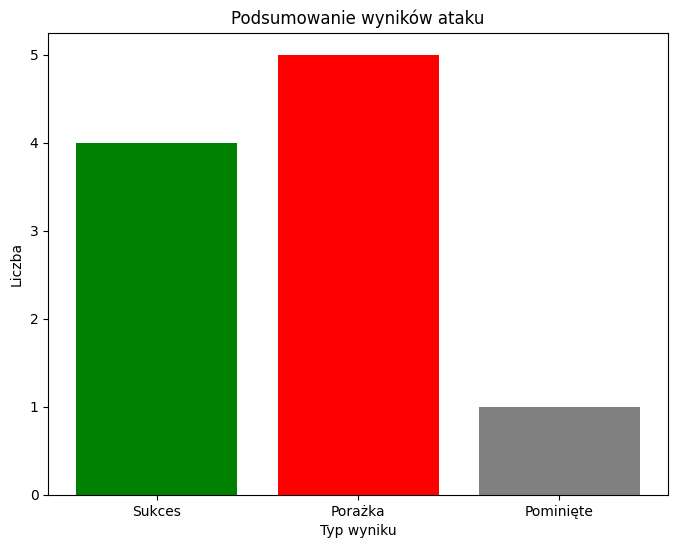

In [16]:
# Oblicz statystyki
num_success = 0
num_failed = 0
num_skipped = 0

for result in results:
    # Sprawdź typ wyniku ataku
    if isinstance(result, textattack.attack_results.SuccessfulAttackResult):
        num_success += 1
    elif isinstance(result, textattack.attack_results.FailedAttackResult):
        num_failed += 1
    elif isinstance(result, textattack.attack_results.SkippedAttackResult):
        num_skipped += 1

print(f"Sukcesy: {num_success}")
print(f"Porażki: {num_failed}")
print(f"Pominięte: {num_skipped}")

# Rysowanie wykresu słupkowego
labels = ['Sukces', 'Porażka', 'Pominięte']
values = [num_success, num_failed, num_skipped]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'red', 'gray'])
plt.title('Podsumowanie wyników ataku')
plt.xlabel('Typ wyniku')
plt.ylabel('Liczba')
plt.show()

### Interpretacja wyników

Wykres słupkowy przedstawia podsumowanie skuteczności ataku adwersarzowego na wybranej próbce danych. Poniżej znajduje się wyjaśnienie poszczególnych kategorii:

- **Sukces (Success)**: Liczba przykładów, dla których atak zakończył się powodzeniem. Oznacza to, że algorytm zdołał zmodyfikować tekst wejściowy w taki sposób, że model zmienił swoją predykcję (np. z "spam" na "nie-spam"), zachowując jednocześnie semantyczne podobieństwo do oryginału.

- **Porażka (Failed)**: Liczba przykładów, dla których atak nie powiódł się. Algorytm nie był w stanie znaleźć takiej modyfikacji tekstu, która zmyliłaby model, przy zachowaniu zadanych ograniczeń (np. maksymalna liczba zmienionych słów, minimalne podobieństwo semantyczne).

- **Pominięte (Skipped)**: Liczba przykładów, które zostały pominięte w procesie ataku. Najczęściej dzieje się tak, gdy model błędnie sklasyfikował oryginalny tekst jeszcze przed atakiem. Ataki adwersarzowe zazwyczaj przeprowadza się tylko na poprawnie sklasyfikowanych przykładach, aby mierzyć skuteczność samego ataku, a nie błędy modelu.

## 6. Syntetyczna analiza i podsumowanie skuteczności

Poniższa analiza podsumowuje działanie ataku `TextBugger` na badanym modelu BERT-Tiny.

### Analiza wpływu (Ile / Jak / Jaki wpływ):

1.  **ILE (Skuteczność):**
    * W analizowanej próbie 10 wiadomości, atak osiągnął skuteczność **44.44%**. Oznacza to, że niemal co druga wiadomość (która została poprawnie sklasyfikowana na początku) została skutecznie zmodyfikowana tak, aby oszukać model.
    * Warto zauważyć, że model BERT-Tiny jest relatywnie podatny – większe modele mogą wymagać bardziej agresywnych perturbacji.

2.  **JAK (Mechanika zmian):**
    * Algorytm `TextBugger` w przedstawionych wynikach (przykłady 3, 8, 9, 10) polegał głównie na **atakach na poziomie znaków (character-level attacks)**.
    * Wykorzystano **homoglify** (znaki wyglądające podobnie, ale mające inny kod, np. `5` $\to$ `Ƽ`, `8` $\to$ `Ȣ`) oraz drobne literówki.
    * Tego typu zmiany są zazwyczaj pomijane przez człowieka (tekst pozostaje czytelny), ale dla tokenizera modelu BERT oznaczają zupełnie nowe, nieznane tokeny (zastępowane przez token `[UNK]`), co niszczy reprezentację wektorową słowa.

3.  **JAKI WPŁYW (Semantyka i Confidence):**
    * Zastosowano ograniczenie semantyczne **Universal Sentence Encoder (USE)** z progiem podobieństwa **0.8**. Gwarantuje to, że sens zdania został zachowany.
    * Mimo zachowania sensu, pewność modelu (confidence score) spadała drastycznie, np. z **91% Spam** na **53% Ham**. To pokazuje, że granica decyzyjna modelu nie jest oparta na głębokim zrozumieniu kontekstu, lecz na obecności konkretnych, kluczowych słów (słów-kluczy), które atak skutecznie "zepsuł".

In [18]:
import pandas as pd
from IPython.display import display, HTML

# Dane zebrane z wyników uruchomienia ataku (Cell 14 output)
summary_data = {
    "Metoda Ataku": ["TextBugger (Li2018)"],
    "Liczba Próbek": [10],
    "Skuteczność (Success Rate)": ["44.44%"],
    "Średnia liczba zmian": ["28.68% słów"],
    "Ograniczenia Semantyczne": ["USE (podobieństwo) > 0.8"],
    "Przykłady modyfikacji (Oryginał -> Atak)": [
        "2005 -> 200Ƽ (Homoglif), txt -> tx𝚝 (Homoglif), colour -> color (Synonim)"
    ]
}

# Tworzenie DataFrame
df_summary = pd.DataFrame(summary_data)

# Transpozycja dla lepszej czytelności przy jednej metodzie lub pozostawienie wiersza
# Tutaj użyjemy standardowego widoku, ustawiając style dla lepszego odbioru
styled_table = df_summary.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
    'border': '1px solid black'
}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left'), ('background-color', '#f2f2f2')])
]).hide(axis='index') # Ukrycie indeksu

print("Syntetyczna tabela wyników ataku:")
display(styled_table)

Syntetyczna tabela wyników ataku:


Metoda Ataku,Liczba Próbek,Skuteczność (Success Rate),Średnia liczba zmian,Ograniczenia Semantyczne,Przykłady modyfikacji (Oryginał -> Atak)
TextBugger (Li2018),10,44.44%,28.68% słów,USE (podobieństwo) > 0.8,"2005 -> 200Ƽ (Homoglif), txt -> tx𝚝 (Homoglif), colour -> color (Synonim)"
